<a href="https://colab.research.google.com/github/porori1224/2024_Chosun_osp_Deepfake-detection-Challenge/blob/main/KMS_Try_Code/After_2nd_Mentoring_00_%EC%86%8D%EB%8F%84_%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
# check the current path
print(os.getcwd()) # /content

# You should copy the path : 왼쪽 폴더에서 오른쪽 버튼 후 경로복사
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW')

print(os.getcwd()) # path has been changed

/content
/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW


In [3]:
!pip install retina-face

In [4]:
!pip install torch torchvision torchaudio

In [5]:
# 필요시 설치
!pip install scikit-learn matplotlib

In [6]:
!pip install timm

In [7]:
import pandas as pd
import json

# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
input_dir = os.path.join(base_dir, "00~01/dfdc_train_part_0")
output_dir = os.path.join(base_dir, "processed_videos00")
os.makedirs(output_dir, exist_ok=True)

# JSON 파일 경로
json_file = os.path.join(input_dir, "metadata.json")

# JSON 파일 로드
with open(json_file, "r") as f:
    metadata = json.load(f)

# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame.from_dict(metadata, orient="index").reset_index()
df.columns = ["filename", "label", "split", "original"]

# 라벨링을 0과 1로 매핑
df["label"] = df["label"].map({"FAKE": 0, "REAL": 1})

In [8]:
# 데이터프레임에서 필요한 컬럼만 출력하도록 정리
print(f"Total data size: {len(df)}")
print(df[["filename", "label", "split", "original"]].head(10))

# 비디오 파일 경로 생성 (dfdc_train_part_0 경로)
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/2024_OSP_SW/00~01/dfdc_train_part_0"
df["filepath"] = df["filename"].apply(lambda x: os.path.join(base_dir, x))


Total data size: 1334
         filename  label  split        original
0  owxbbpjpch.mp4      0  train  wynotylpnm.mp4
1  vpmyeepbep.mp4      1  train             NaN
2  fzvpbrzssi.mp4      1  train             NaN
3  htorvhbcae.mp4      0  train  wclvkepakb.mp4
4  fckxaqjbxk.mp4      0  train  vpmyeepbep.mp4
5  sphirandia.mp4      0  train  jawgcggquk.mp4
6  vsmadeuczx.mp4      0  train  qarqtkvgby.mp4
7  ohaqlzfnuv.mp4      0  train  sttnfyptum.mp4
8  komngcqveq.mp4      0  train  kqlvggiqee.mp4
9  iafvzgpbix.mp4      0  train  lzbmwwejxb.mp4


In [13]:
import os
import pandas as pd
import json
import cv2
from retinaface import RetinaFace
from multiprocessing import Pool
from torchvision import transforms
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pickle

# 비디오 처리 함수
skipped_videos = set()  # 중복 방지
data_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

def process_video(video_info):
    video_path, output_path = video_info
    try:
        # 비디오 열기
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Skipping invalid video: {video_path}")
            skipped_videos.add(video_path)
            return None

        # 프레임 읽기
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        mid_frame_idx = frame_count // 2
        random_frame_idx = random.randint(0, frame_count - 1)
        selected_frames = [mid_frame_idx, random_frame_idx]

        frames = []
        for idx in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                break
            if idx in selected_frames:
                frames.append(frame)
        cap.release()

        if not frames:
            print(f"No frames selected: {video_path}")
            skipped_videos.add(video_path)
            return None

        # 얼굴 감지 및 데이터 증강
        for frame in frames:
            resized_frame = cv2.resize(frame, (160, 90))  # 해상도 축소
            faces = RetinaFace.detect_faces(resized_frame)
            if isinstance(faces, dict) and faces:
                bbox = list(faces.values())[0]["facial_area"]
                cropped_face = resized_frame[bbox[1]:bbox[3], bbox[0]:bbox[2]]

                # 데이터 증강
                augmented_face = data_augment(cropped_face)

                # 이미지 저장
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                augmented_image = transforms.ToPILImage()(augmented_face)
                augmented_image.save(output_path)
                print(f"Processed and saved: {output_path}")
                return output_path

        print(f"Skipping video without detectable faces: {video_path}")
        skipped_videos.add(video_path)
        return None

    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        skipped_videos.add(video_path)
        return None

# 비디오 정보 리스트 생성
video_info_list = [
    (os.path.join(input_dir, filename), os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_processed.jpg"))
    for filename in os.listdir(input_dir) if filename.endswith(".mp4")
]

# 병렬 처리 함수
def process_videos_in_parallel(video_info_list, num_processes=os.cpu_count()):
    with Pool(processes=num_processes) as pool:
        results = pool.map(process_video, video_info_list)
    return results

# 실행
if __name__ == "__main__":
    print("Starting optimized video processing...")
    processed_files = process_videos_in_parallel(video_info_list, num_processes=4)
    print("Processing complete.")

    # 스킵된 비디오 저장
    skipped_videos_path = os.path.join(base_dir, "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/skipped_videos00.txt")
    with open(skipped_videos_path, "w") as f:
        for video in skipped_videos:
            f.write(f"{video}\n")
    print(f"Skipped videos saved to: {skipped_videos_path}")

Starting optimized video processing...
24-12-02 16:48:45 - Directory /root/.deepface created
24-12-02 16:48:45 - Directory /root/.deepface/weights created
24-12-02 16:48:45 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
24-12-02 16:48:45 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
24-12-02 16:48:45 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
24-12-02 16:48:45 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
  0%|          | 0.00/119M [00:00<?, ?B/s]Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
  0%|          | 0.00/119M [00:00<?, ?B/s]Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
  0%|          | 0.00/119M [00:00<?, ?B/s]Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 197MB/s]
100%|██████████| 119M/119M [00:00<00:00, 192MB/s]
100%|██████████| 119M/119M [00:00<00:00, 201MB/s]
100%|██████████| 119M/119M [00:00<00:00, 207MB/s]


Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/xewwsdhdro_processed.jpg
Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/bmhghysucl_processed.jpg
Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/yajhwipypq_processed.jpgProcessed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/yptchajnvb_processed.jpg

Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/itwvssoevj_processed.jpg
Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/udxqbhgvvx_processed.jpg
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/culaevxduf.mp4
Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos00/jphmkhpoeb_processed.jpg
Processed and saved: /content/gdrive/MyDrive/Colab Notebo

In [14]:
# 처리된 데이터 개수 확인 및 출력
print(f"Total processed videos: {len(processed_files)}")

Total processed videos: 1334


In [15]:
print(f"Skipped videos set: {skipped_videos}")

Skipped videos set: set()


In [87]:
# 스킵된 비디오 로그 확인
skipped_videos_path = os.path.join(base_dir, "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/skipped_videos00.txt")
with open(skipped_videos_path, "r") as f:
    skipped_videos = f.readlines()
print(f"Skipped videos: {len(skipped_videos)}")
print(f"Sample skipped videos: {skipped_videos[:5]}")

Skipped videos: 0
Sample skipped videos: []


In [31]:
# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
input_dir = os.path.join(base_dir, "00~01/dfdc_train_part_0")
output_dir = os.path.join(base_dir, "processed_videos00")
os.makedirs(output_dir, exist_ok=True)

## 데이터 균형 조정
fake_df = df[df["label"] == 0]
real_df = df[df["label"] == 1]
fake_sampled = resample(fake_df, replace=False, n_samples=len(real_df), random_state=42)
balanced_df = pd.concat([real_df, fake_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# 데이터 크기 확인
print(f"Filtered DataFrame size: {len(df)}")
print(df["label"].value_counts())  # 각 클래스별 데이터 수 확인

# 데이터 분리 (80% Train + Validation, 20% Test)
train_val_df, test_df = train_test_split(
    balanced_df,
    test_size=0.2,
    random_state=42,
    stratify=balanced_df["label"]
)

# Train과 Validation 데이터 분리 (Train: 80%, Validation: 20%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    random_state=42,
    stratify=train_val_df["label"]
)

# Split 열 업데이트
train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"

# 분리된 데이터 크기 확인
print(f"Train DataFrame size: {len(train_df)}")
print(f"Validation DataFrame size: {len(val_df)}")
print(f"Test DataFrame size: {len(test_df)}")

# 클래스별 데이터 크기 확인
print("\nLabel distribution in Train Data:")
print(train_df["label"].value_counts())
print("\nLabel distribution in Validation Data:")
print(val_df["label"].value_counts())
print("\nLabel distribution in Test Data:")
print(test_df["label"].value_counts())

# Pickle 저장 경로
train_pickle_path = os.path.join(base_dir, "train_split00.pkl")
val_pickle_path = os.path.join(base_dir, "val_split00.pkl")
test_pickle_path = os.path.join(base_dir, "test_split00.pkl")

with open(train_pickle_path, "wb") as f:
    pickle.dump(train_df, f)
with open(val_pickle_path, "wb") as f:
    pickle.dump(val_df, f)
with open(test_pickle_path, "wb") as f:
    pickle.dump(test_df, f)

print(f"Train data saved to: {train_pickle_path}")
print(f"Validation data saved to: {val_pickle_path}")
print(f"Test data saved to: {test_pickle_path}")

Filtered DataFrame size: 1334
label
0    1248
1      86
Name: count, dtype: int64
Train DataFrame size: 109
Validation DataFrame size: 28
Test DataFrame size: 35

Label distribution in Train Data:
label
1    55
0    54
Name: count, dtype: int64

Label distribution in Validation Data:
label
1    14
0    14
Name: count, dtype: int64

Label distribution in Test Data:
label
0    18
1    17
Name: count, dtype: int64
Train data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/train_split00.pkl
Validation data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/val_split00.pkl
Test data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/test_split00.pkl


In [17]:
# Fake와 Real 데이터 균형 맞추기
def balance_data(df):
    fake_df = df[df['label'] == 0]
    real_df = df[df['label'] == 1]
    n_samples = min(len(fake_df), len(real_df))  # 두 클래스 중 더 적은 데이터 개수 선택
    fake_sampled = resample(fake_df, replace=False, n_samples=n_samples, random_state=42)
    real_sampled = resample(real_df, replace=False, n_samples=n_samples, random_state=42)
    balanced_df = pd.concat([real_sampled, fake_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

balanced_train_df = balance_data(train_df)
balanced_val_df = balance_data(val_df)
balanced_test_df = balance_data(test_df)

# 파일명과 라벨 매핑 생성 함수
def create_labels(df, processed_files):
    labels = {}
    for filename, label in zip(df["filename"], df["label"]):
        base_filename = os.path.splitext(filename)[0]
        processed_filename = f"{base_filename}_processed.jpg"
        if processed_filename in processed_files:
            labels[processed_filename] = label
    return labels

# Split 열 업데이트
train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"


In [18]:
import os
import pandas as pd
import pickle

# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
train_pickle_path = os.path.join(base_dir, "train_split00.pkl")
val_pickle_path = os.path.join(base_dir, "val_split00.pkl")
test_pickle_path = os.path.join(base_dir, "test_split00.pkl")

# Pickle 파일 로드
with open(train_pickle_path, "rb") as f:
    train_df = pickle.load(f)

with open(val_pickle_path, "rb") as f:
    val_df = pickle.load(f)

with open(test_pickle_path, "rb") as f:
    test_df = pickle.load(f)

# 데이터 크기 및 라벨 분포 확인
print(f"Train DataFrame size: {len(train_df)}")
print(f"Validation DataFrame size: {len(val_df)}")
print(f"Test DataFrame size: {len(test_df)}")

print("\nLabel distribution in Train Data:")
print(train_df["label"].value_counts())

print("\nLabel distribution in Validation Data:")
print(val_df["label"].value_counts())

print("\nLabel distribution in Test Data:")
print(test_df["label"].value_counts())

# 데이터 샘플 확인
print("\nTrain DataFrame Sample:")
print(train_df.head())

print("\nValidation DataFrame Sample:")
print(val_df.head())

print("\nTest DataFrame Sample:")
print(test_df.head())

# 처리된 비디오 파일 확인
processed_dir = os.path.join(base_dir, "processed_videos00")
processed_files = os.listdir(processed_dir)
print(f"\nTotal processed video files: {len(processed_files)}")
print(f"Sample processed files: {processed_files[:5]}")

# 처리된 파일이 Pickle에 매핑된 데이터와 일치하는지 확인
mapped_files = train_df["filepath"].apply(lambda x: os.path.basename(x)).tolist()
unmatched_files = set(mapped_files) - set(processed_files)
print(f"\nUnmatched files in Train Data: {len(unmatched_files)}")
if unmatched_files:
    print(f"Unmatched file samples: {list(unmatched_files)[:5]}")
else:
    print("All files in Train Data are correctly processed and mapped.")

Train DataFrame size: 109
Validation DataFrame size: 28
Test DataFrame size: 35

Label distribution in Train Data:
label
1    55
0    54
Name: count, dtype: int64

Label distribution in Validation Data:
label
1    14
0    14
Name: count, dtype: int64

Label distribution in Test Data:
label
0    18
1    17
Name: count, dtype: int64

Train DataFrame Sample:
           filename  label  split        original  \
165  xnfrhixfym.mp4      0  train  fsaronfupy.mp4   
104  hasjjkoygr.mp4      0  train  fopjiyxiqd.mp4   
107  runmncglnj.mp4      0  train  gnmmhlbzge.mp4   
99   fopjiyxiqd.mp4      1  train             NaN   
73   vpmyeepbep.mp4      1  train             NaN   

                                              filepath  
165  /content/gdrive/MyDrive/Colab Notebooks/2024_O...  
104  /content/gdrive/MyDrive/Colab Notebooks/2024_O...  
107  /content/gdrive/MyDrive/Colab Notebooks/2024_O...  
99   /content/gdrive/MyDrive/Colab Notebooks/2024_O...  
73   /content/gdrive/MyDrive/Colab Not

In [19]:
# Train 데이터와 처리된 파일 매칭 검증
mapped_files = train_df["filename"].apply(lambda x: os.path.splitext(x)[0] + "_processed.jpg").tolist()
unmatched_files = set(mapped_files) - set(processed_files)
print(f"\nUnmatched files in Train Data after fix: {len(unmatched_files)}")
if unmatched_files:
    print(f"Unmatched file samples: {list(unmatched_files)[:5]}")
else:
    print("All files in Train Data are correctly processed and mapped.")


Unmatched files in Train Data after fix: 23
Unmatched file samples: ['iocjgjemeb_processed.jpg', 'hwcnsgqzld_processed.jpg', 'aayrffkzxn_processed.jpg', 'runmncglnj_processed.jpg', 'wfzjxzhdkj_processed.jpg']


Training Ensemble Model with Visualization...


Epoch 1/10: 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


Ensemble Epoch 1/10 - Train Loss: 0.7510


Epoch 2/10: 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]


Ensemble Epoch 2/10 - Train Loss: 0.6972


Epoch 3/10: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Ensemble Epoch 3/10 - Train Loss: 0.6361


Epoch 4/10: 100%|██████████| 6/6 [00:00<00:00,  7.10it/s]


Ensemble Epoch 4/10 - Train Loss: 0.5989


Epoch 5/10: 100%|██████████| 6/6 [00:00<00:00,  7.08it/s]


Ensemble Epoch 5/10 - Train Loss: 0.5672


Epoch 6/10: 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]


Ensemble Epoch 6/10 - Train Loss: 0.5346


Epoch 7/10: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


Ensemble Epoch 7/10 - Train Loss: 0.4924


Epoch 8/10: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Ensemble Epoch 8/10 - Train Loss: 0.4349


Epoch 9/10: 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


Ensemble Epoch 9/10 - Train Loss: 0.3962


Epoch 10/10: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


Ensemble Epoch 10/10 - Train Loss: 0.3500


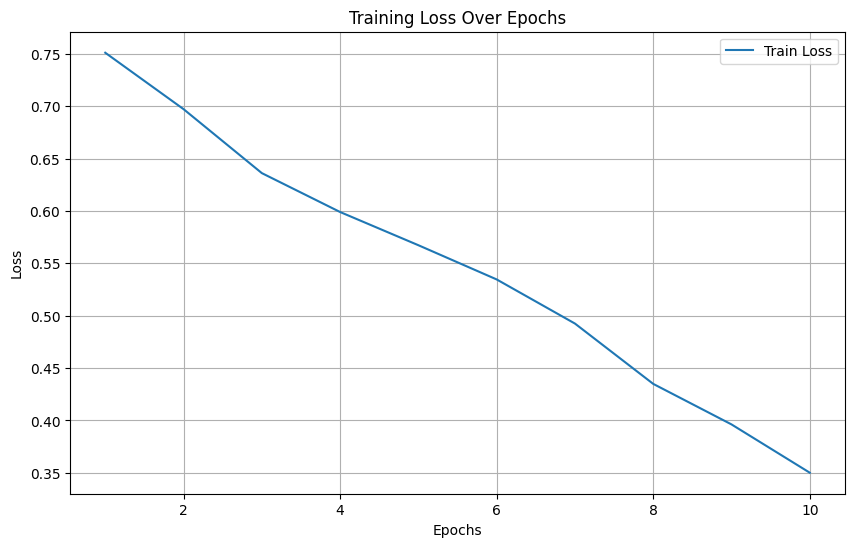

In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from timm import create_model
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

# 데이터셋 클래스 정의
class ProcessedDataset(Dataset):
    def __init__(self, image_dir, labels, transform=None):
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform
        self.image_files = list(labels.keys())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        label = self.labels[image_file]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


# processed_dir 내 파일 가져오기
processed_files = set(os.listdir(processed_dir))
train_labels = create_labels(balanced_train_df, processed_files)
val_labels = create_labels(balanced_val_df, processed_files)
test_labels = create_labels(balanced_test_df, processed_files)

# 이미지 전처리(transformations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 및 DataLoader 생성
train_dataset = ProcessedDataset(processed_dir, train_labels, transform=transform)
val_dataset = ProcessedDataset(processed_dir, val_labels, transform=transform)
test_dataset = ProcessedDataset(processed_dir, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# EfficientNet-B0 정의
class CustomEfficientNetB0(nn.Module):
    def __init__(self, pretrained=True, num_classes=1):
        super(CustomEfficientNetB0, self).__init__()
        self.backbone = create_model("efficientnet_b0", pretrained=True)
        self.backbone.reset_classifier(0)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.dropout(x)
        x = x.mean(dim=[2, 3])
        x = self.fc(x)
        return x

# ConvNextTiny 정의
class CustomConvNextTiny(nn.Module):
    def __init__(self, pretrained=True, num_classes=1):
        super(CustomConvNextTiny, self).__init__()
        self.backbone = create_model("convnext_tiny", pretrained=True)
        self.backbone.reset_classifier(0)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.dropout(x)
        x = x.mean(dim=[2, 3])
        x = self.fc(x)
        return x

# EfficientNet-B0 + ConvNextTiny 앙상블 모델 정의
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, num_classes=1):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        combined = torch.cat((output1, output2), dim=1)
        return self.fc(combined)

# 모델 초기화
efficientnet_b0 = CustomEfficientNetB0(pretrained=True)
convnext_tiny = CustomConvNextTiny(pretrained=True)
ensemble_model = EnsembleModel(efficientnet_b0, convnext_tiny)
ensemble_model = ensemble_model.cuda()

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
optimizer_ensemble = optim.Adam(ensemble_model.parameters(), lr=1e-4, weight_decay=1e-4)

# 학습 및 시각화 함수
def train_ensemble_with_visualization(model, optimizer, train_loader, num_epochs):
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Ensemble Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}")

    # 학습 손실 시각화 저장
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("training_loss_plot.png")
    plt.show()

# 학습 실행 및 시각화
print("Training Ensemble Model with Visualization...")
train_ensemble_with_visualization(ensemble_model, optimizer_ensemble, train_loader, num_epochs=10)

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train 데이터 평가 함수
def evaluate_train(model, train_loader):
    model.eval()  # 평가 모드로 전환
    y_true = []
    y_pred = []

    # GPU/CPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for images, labels in train_loader:
            # 데이터를 GPU/CPU로 이동
            images = images.to(device)
            labels = labels.to(device)

            # 모델 예측
            outputs = model(images)
            preds = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int)

            # 실제 라벨 및 예측 라벨 저장
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.flatten().tolist())

    # 성능 지표 계산
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # 결과 출력
    print("\nTrain Dataset Evaluation Metrics:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1 Score: {f1*100:.2f}%")

# Validation 데이터 평가 함수
def evaluate_validation(model, val_loader):
    model.eval()  # 평가 모드로 전환
    y_true = []
    y_pred = []

    # GPU/CPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for images, labels in val_loader:
            # 데이터를 GPU/CPU로 이동
            images = images.to(device)
            labels = labels.to(device)

            # 모델 예측
            outputs = model(images)
            preds = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int)

            # 실제 라벨 및 예측 라벨 저장
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.flatten().tolist())

    # 성능 지표 계산
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # 결과 출력
    print("\nValidation Dataset Evaluation Metrics:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1 Score: {f1*100:.2f}%")

# Train 데이터 평가
print("Evaluating Train Data...")
evaluate_train(ensemble_model, train_loader)

# Validation 데이터 평가
print("\nEvaluating Validation Data...")
evaluate_validation(ensemble_model, val_loader)

Evaluating Train Data...

Train Dataset Evaluation Metrics:
Accuracy: 98.82%
Precision: 100.00%
Recall: 97.87%
F1 Score: 98.92%

Evaluating Validation Data...

Validation Dataset Evaluation Metrics:
Accuracy: 53.85%
Precision: 53.33%
Recall: 61.54%
F1 Score: 57.14%


In [22]:
# Test 데이터셋 정의
test_dataset = ProcessedDataset(
    processed_dir,
    test_labels,  # Test 데이터의 라벨
    transform=transform  # 이미지 전처리
    # apply_retinaface=False  # 제거
)

# Test DataLoader 정의
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4  # 데이터 로딩 속도 최적화
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 모델을 평가 모드로 전환
ensemble_model.eval()

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)

# 실제 라벨 및 예측 라벨 리스트 초기화
y_true = []
y_pred = []

# Test 데이터셋을 사용한 평가
with torch.no_grad():
    for images, labels in test_loader:
        # 데이터를 GPU/CPU로 이동
        images = images.to(device)
        labels = labels.to(device)

        # 실제 라벨 저장
        y_true.extend(labels.cpu().numpy())  # CPU로 이동하여 numpy로 변환

        # 모델 예측
        outputs = ensemble_model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()  # Sigmoid 활성화 함수
        y_pred.extend((preds > 0.5).astype(int).flatten())  # 0.5 이상이면 1로 변환

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# 결과 출력
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1 Score: {f1 * 100:.2f}%")

Test Accuracy: 48.00%
Test Precision: 60.00%
Test Recall: 56.25%
Test F1 Score: 58.06%
